In [30]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import matplotlib.pyplot as plt
import numpy as np
from configs.RecursiveVPSDE.LSTM_fMullerBrown.recursive_LSTM_PostMeanScore_MullerBrown_T256_H05_tl_110data import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
config = get_config()

In [32]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape == y_pred.shape)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [33]:
ts_type = "MullerBrown"
include = (f"{config.t0}t0_{config.deltaT:.3e}dT").replace(".", "")

In [34]:
import os
keepfiles = []
root_dir = project_config.ROOT_DIR + f"experiments/results/"
for file in os.listdir(root_dir):
    if "Nadaraya" in file and ts_type in file and include in file and "DriftEvalExp" in file:
        keepfiles.append(root_dir+file)
print(len(keepfiles), ts_type)
assert len(keepfiles)>0, "No files found"
def extract_bw_number(s):
    match = s.split("/")[-1].split("_")[3][:-2]
    return float("0." + match)

keepfiles = sorted(keepfiles, key=extract_bw_number)
Xshape = np.load(keepfiles[0]).shape[0]
bws = [extract_bw_number(f) for f in keepfiles]

39 MullerBrown


In [35]:
def find_true_drift(prev, numXs, config):
    assert (prev.shape == (numXs, config.ndims))
    Aks = np.array(config.Aks)[np.newaxis, :]
    aks = np.array(config.aks)[np.newaxis, :]
    bks = np.array(config.bks)[np.newaxis, :]
    cks = np.array(config.cks)[np.newaxis, :]
    X0s = np.array(config.X0s)[np.newaxis, :]
    Y0s = np.array(config.Y0s)[np.newaxis, :]
    common = Aks * np.exp(aks* np.power(prev[:,[0]] - X0s, 2) \
                                 + bks* (prev[:,[0]] - X0s) * (prev[:, [1]] - Y0s)
                                 + cks* np.power(prev[:, [1]] - Y0s, 2))
    assert (common.shape == (numXs, 4))
    drift_X = np.zeros((numXs, config.ndims))
    drift_X[:, 0] = -np.sum(common * (2. * aks* (prev[:, [0]] - X0s) + bks* (prev[:, [1]] - Y0s)), axis=1)
    drift_X[:, 1] = -np.sum(common * (2. * cks* (prev[:, [1]] - Y0s) + bks* (prev[:, [0]] - X0s)), axis=1)

    return drift_X

In [36]:
numXs = 25
minx = -1.
maxx = -0.9
Xs = np.linspace(minx, maxx, numXs)
miny = 1.
maxy = 1.1
Ys = np.linspace(miny, maxy, numXs)
X, Y = np.meshgrid(Xs, Ys)
Xs = np.column_stack([X.ravel(), Y.ravel()])
num_paths = 10952
is_true_drifts = find_true_drift(prev=Xs, numXs=Xshape, config=config)
print(ts_type)

MullerBrown


In [37]:
def plot_drift_estimator(mean, true_drift, coords, bw, toSave:bool = False):
    fig, ax = plt.subplots(figsize=(20,12))
    rmse = rmse_ignore_nans(true_drift, mean).astype(np.float64)#np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
    error_data = np.power(np.mean(np.power(true_drift  - mean,2), axis=-1), 0.5)
    assert (error_data.shape == (true_drift.shape[0],))

    # Extract x and y from coordinates
    x, y = coords[:, 0], coords[:, 1]

    # Create a heatmap using tricontourf
    plt.tricontourf(x, y, error_data, levels=20, cmap="hot")  # Contour plot with 20 levels
    cbar = plt.colorbar(label="RMSE Value")  # Add color bar
    cbar.ax.tick_params(labelsize=38)  # Change font size of numbers on colorbar
    cbar.set_label("RMSE Value", fontsize=38)
    ax.set_title(rf"RMSE {round(rmse,3)} for Nadaraya Estimator", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $X_{1}$", fontsize=38)
    ax.set_ylabel("State $X_{2}$", fontsize=38)
    ax.legend(fontsize=24)
    plt.tight_layout()
    if toSave:
        plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/IIDNadaraya_DriftEvalExp_fMullerBrown_{round(bw, 6)}bw").replace(".", "")+".png")
    plt.show()
    plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


BW IDX: 0



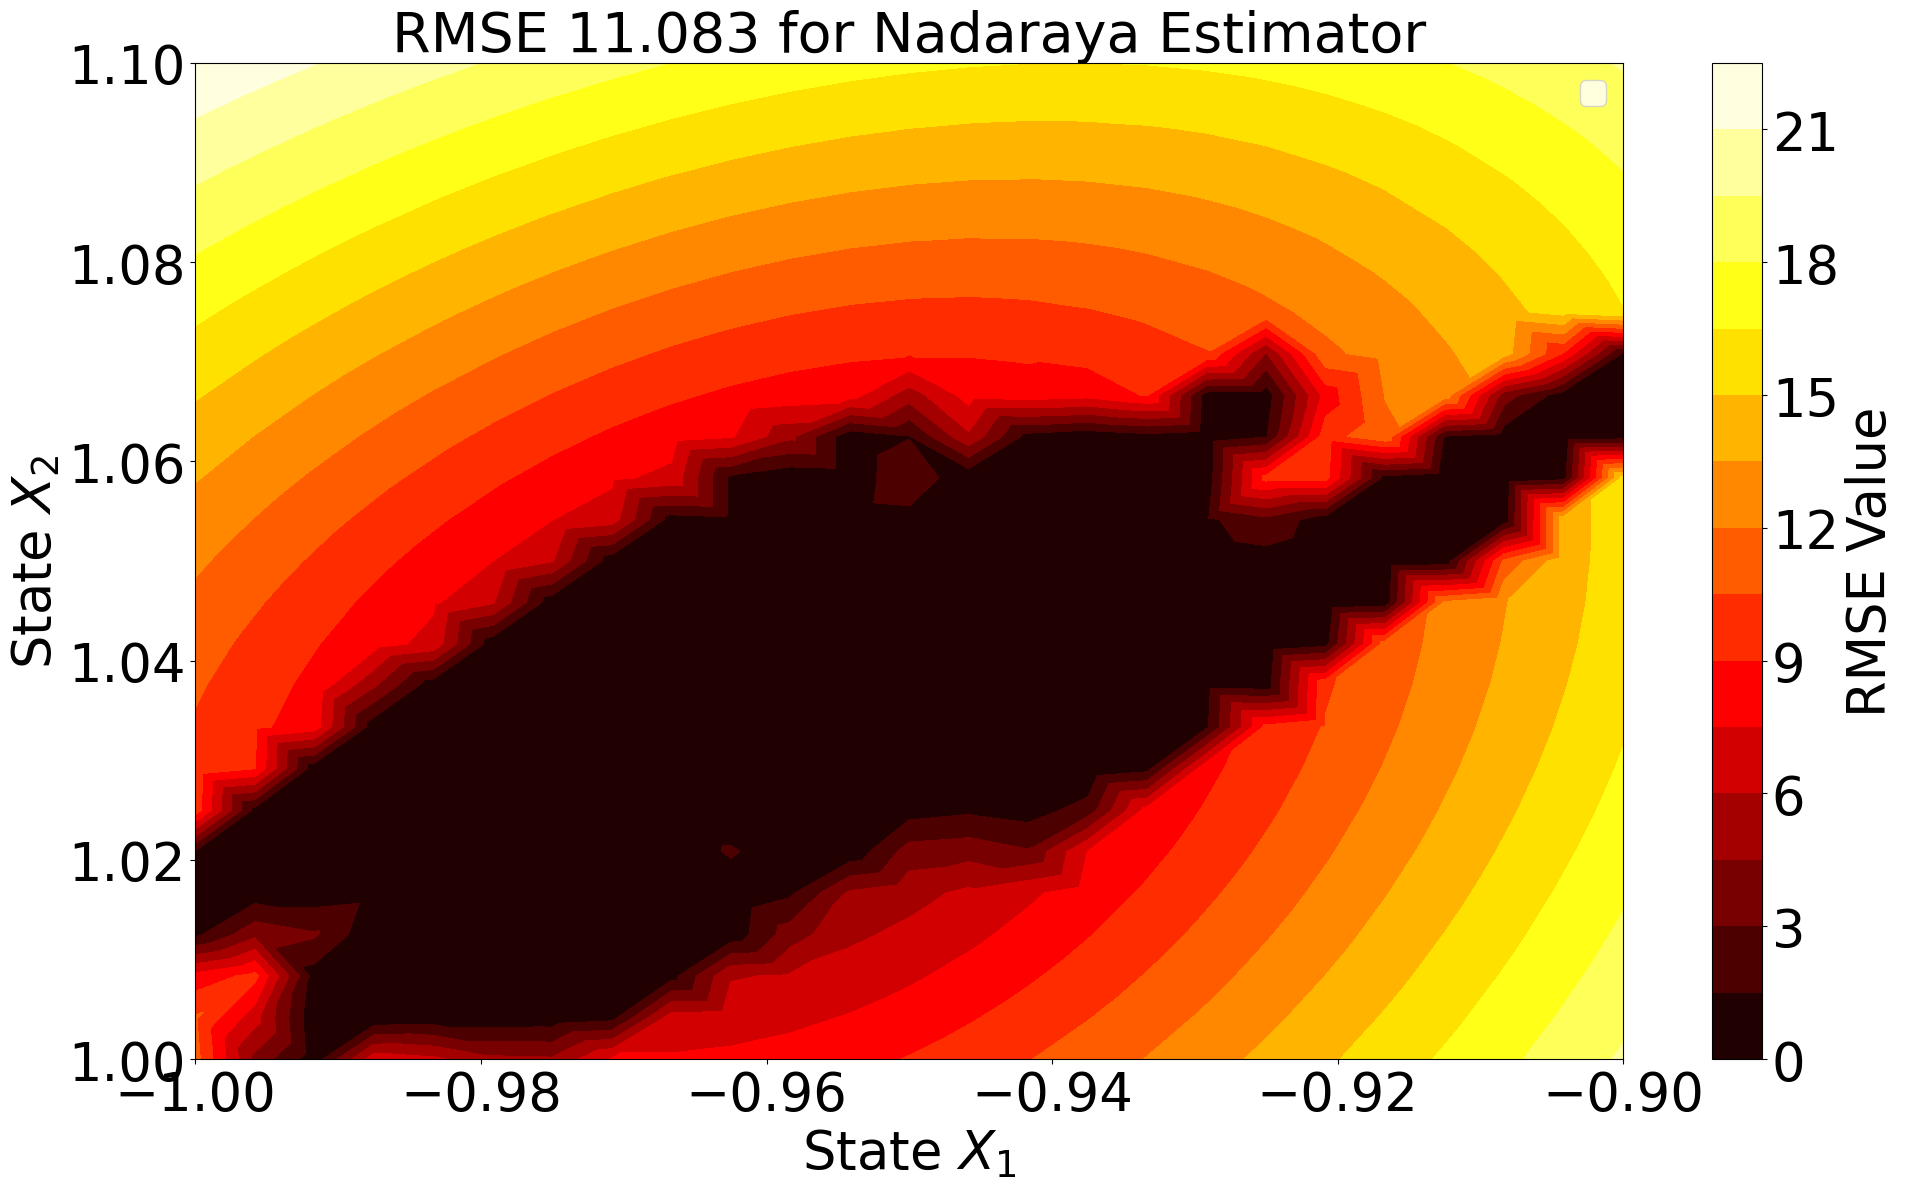

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bandwidth 1e-05 done with Best RMSE 11.082826726019146




BW IDX: 1



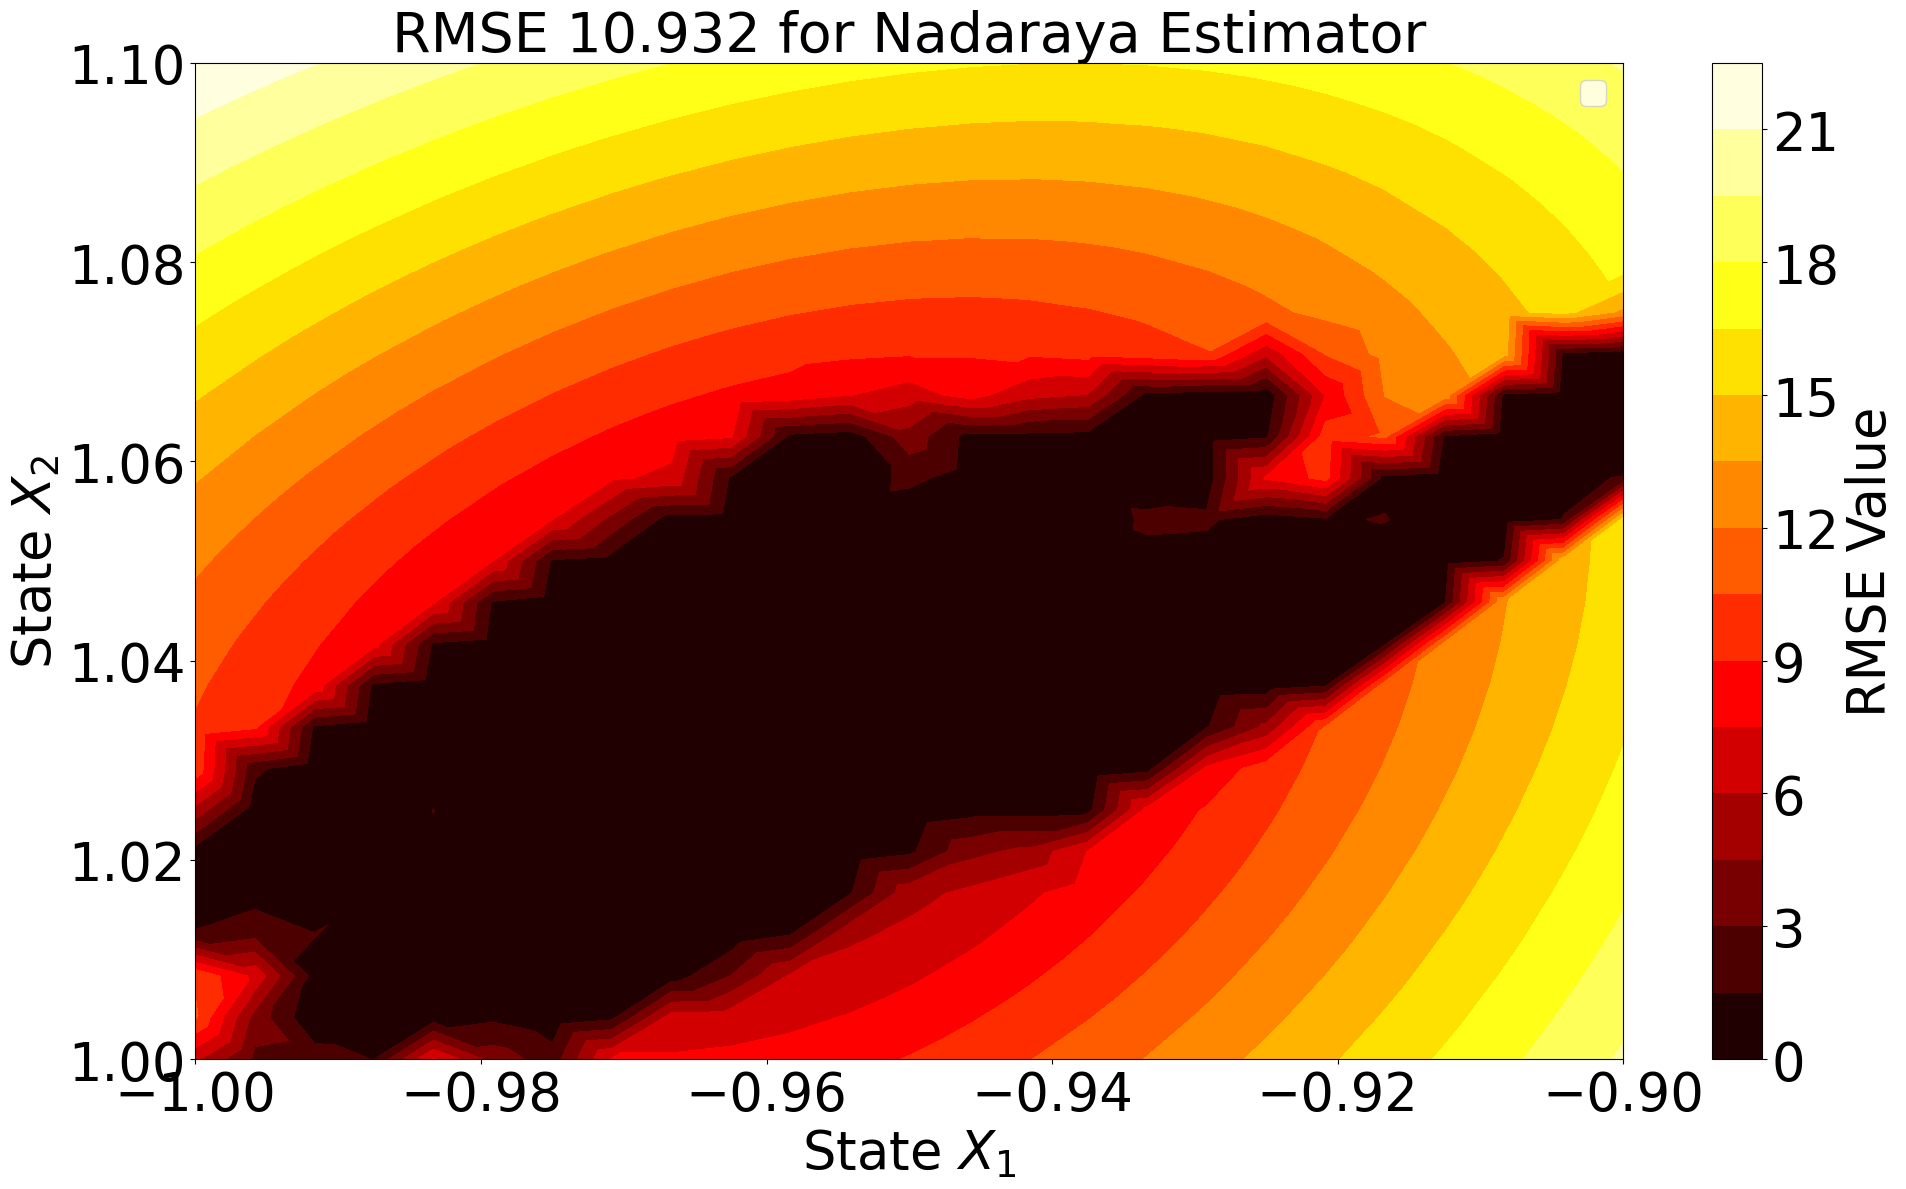

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bandwidth 1.2626472909607102e-05 done with Best RMSE 10.932021059404343




BW IDX: 2



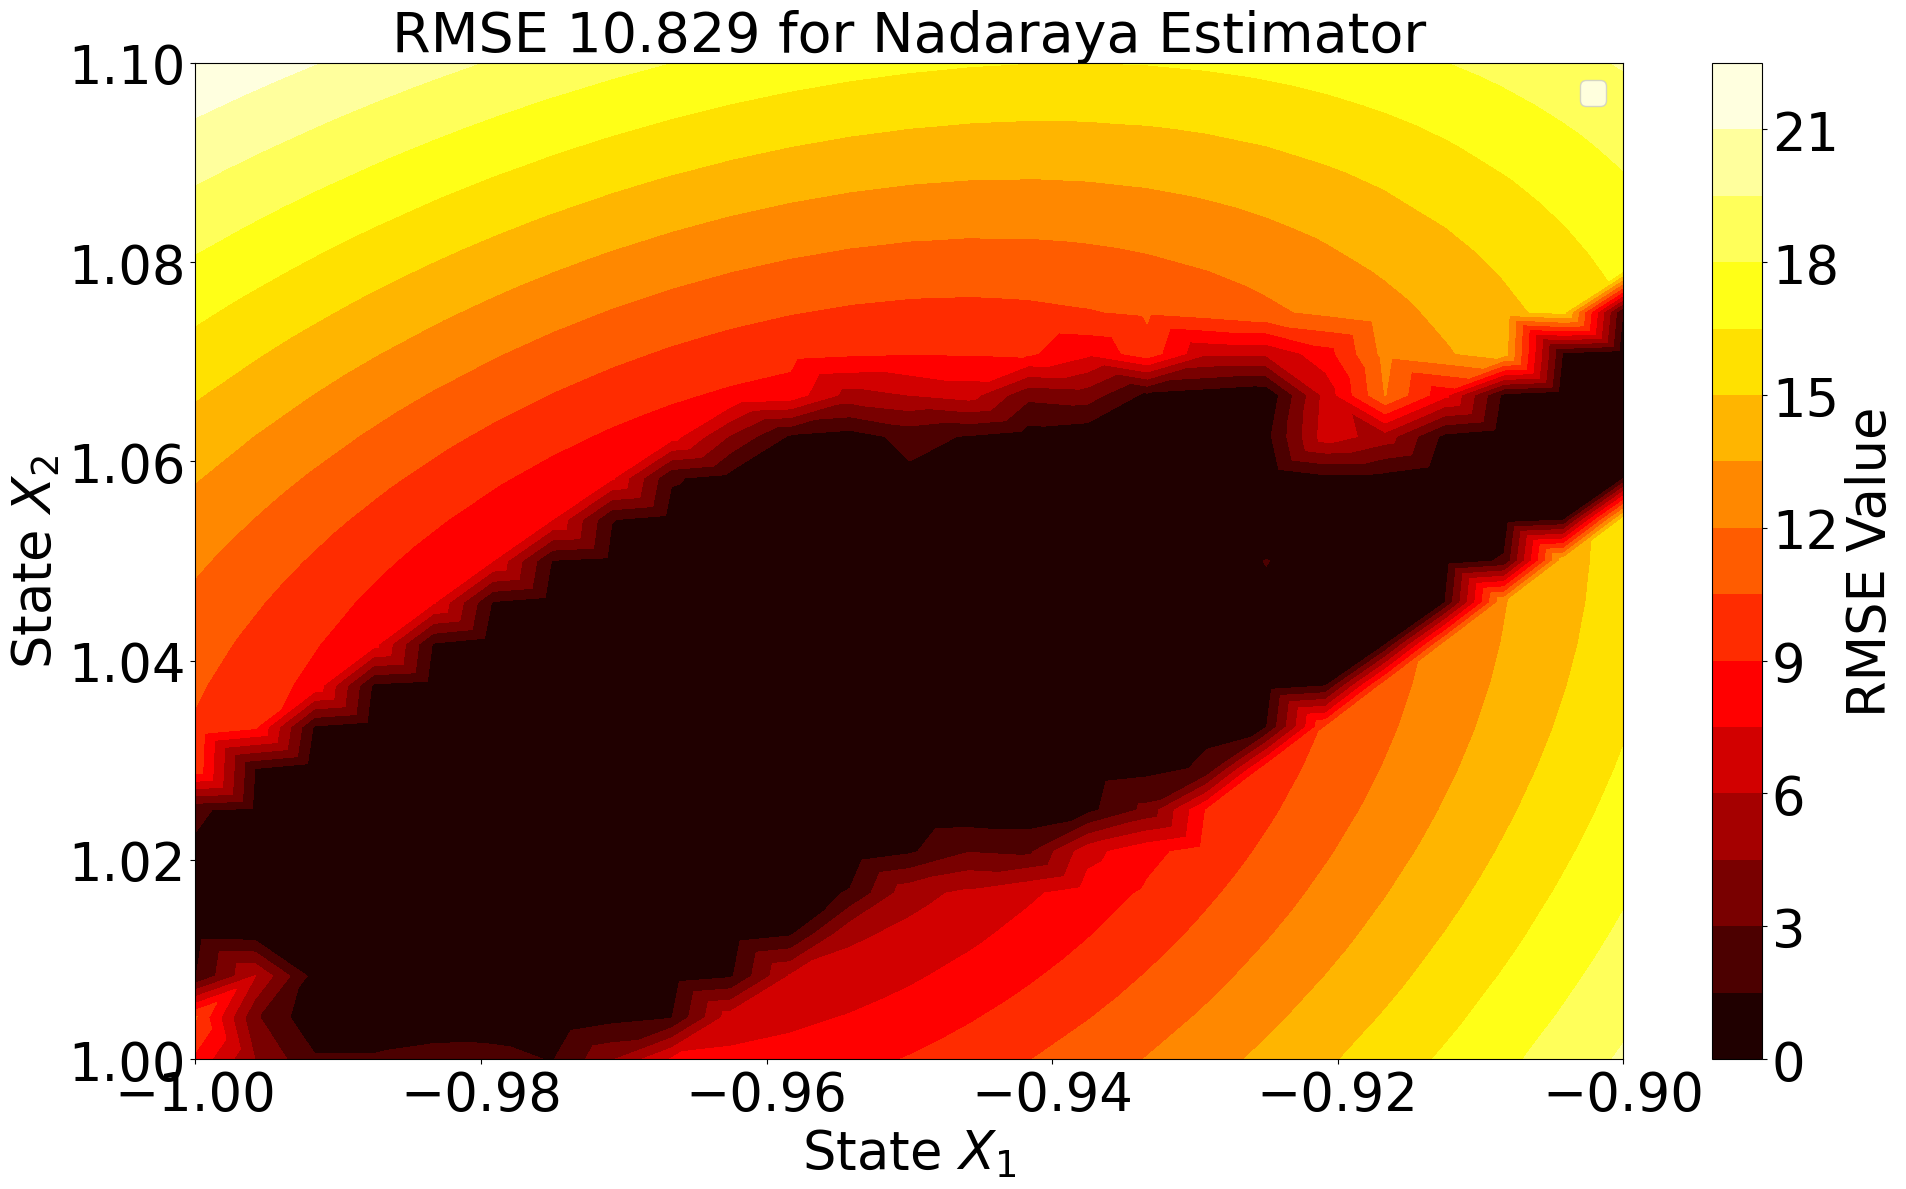

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bandwidth 1.59427818137042e-05 done with Best RMSE 10.828998308083367




BW IDX: 3



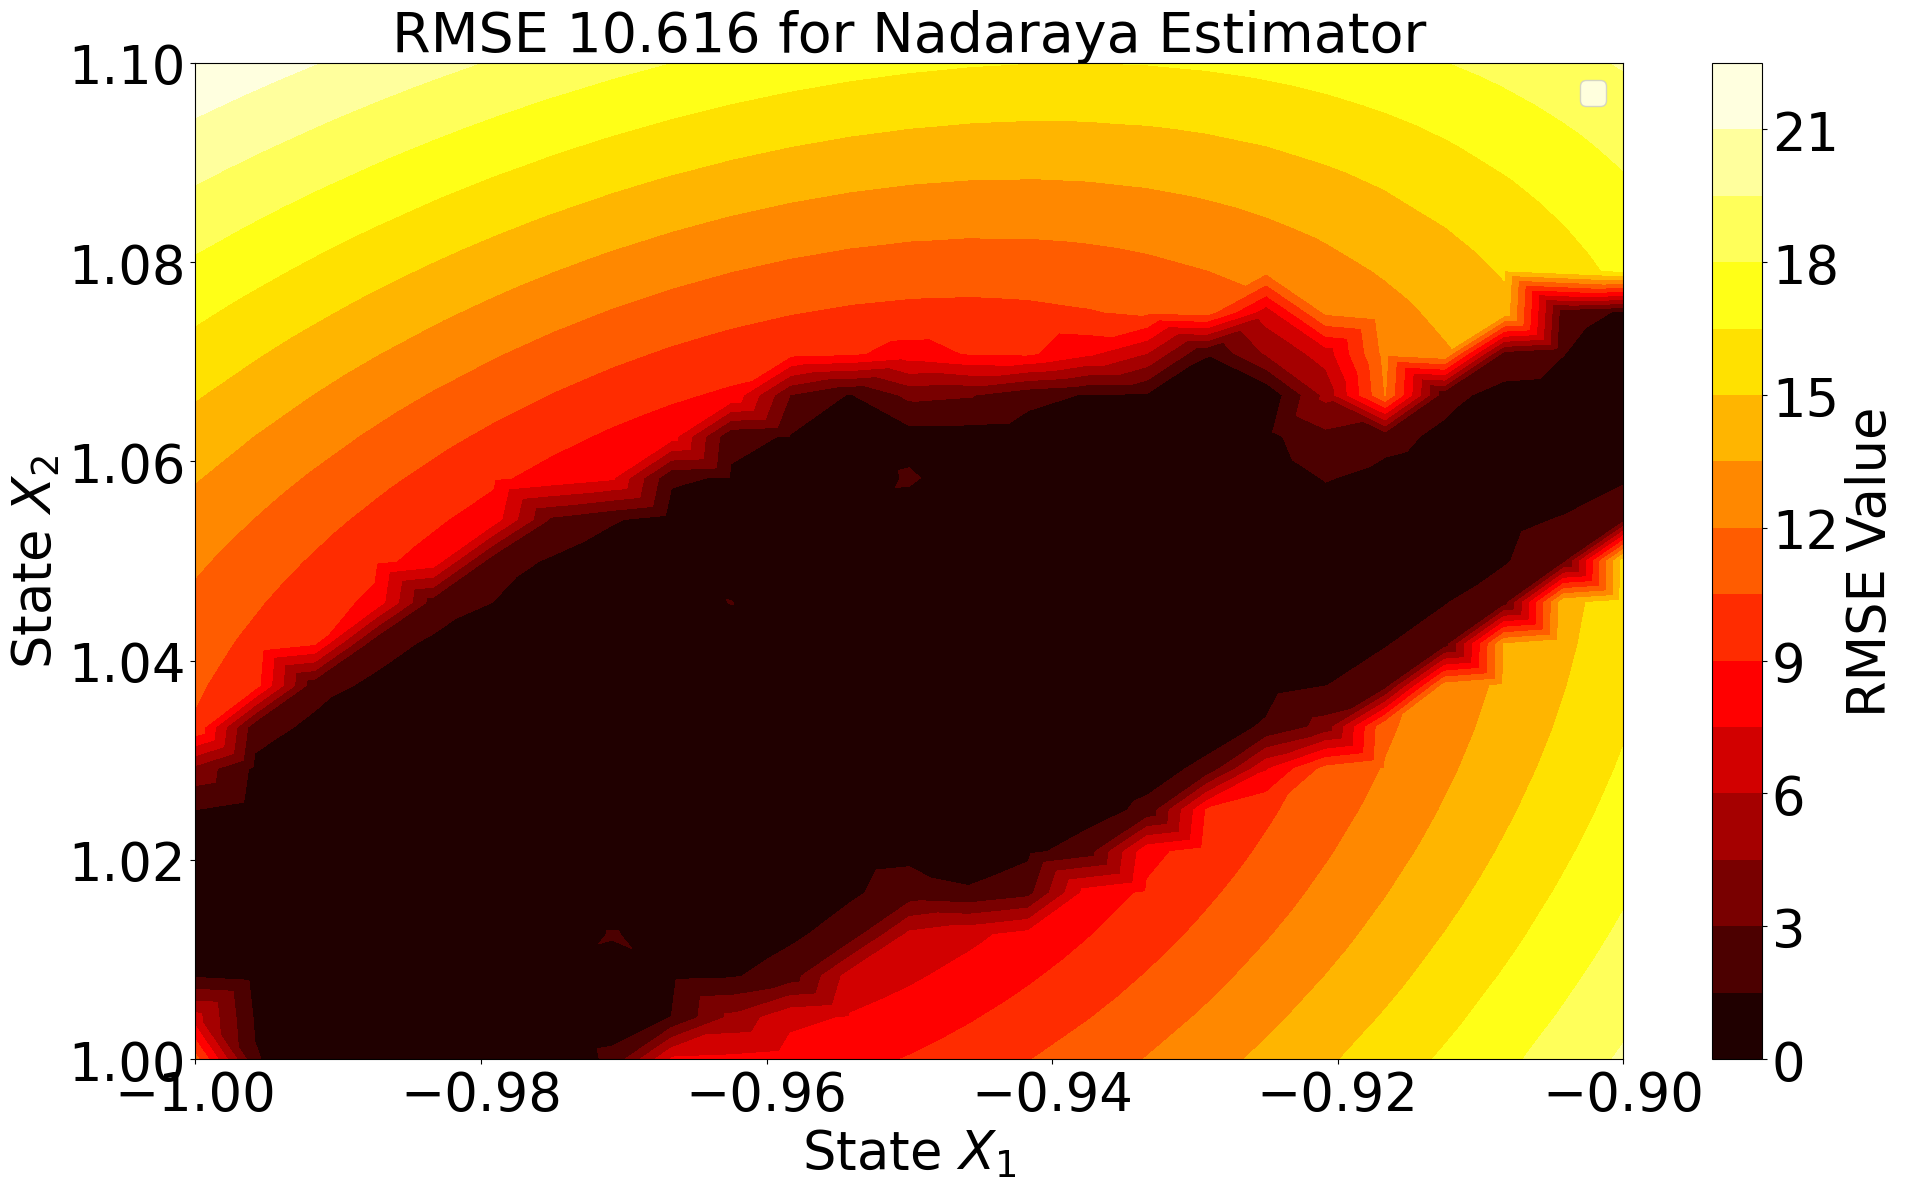

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bandwidth 2.0130110267451266e-05 done with Best RMSE 10.615621501531153




BW IDX: 4



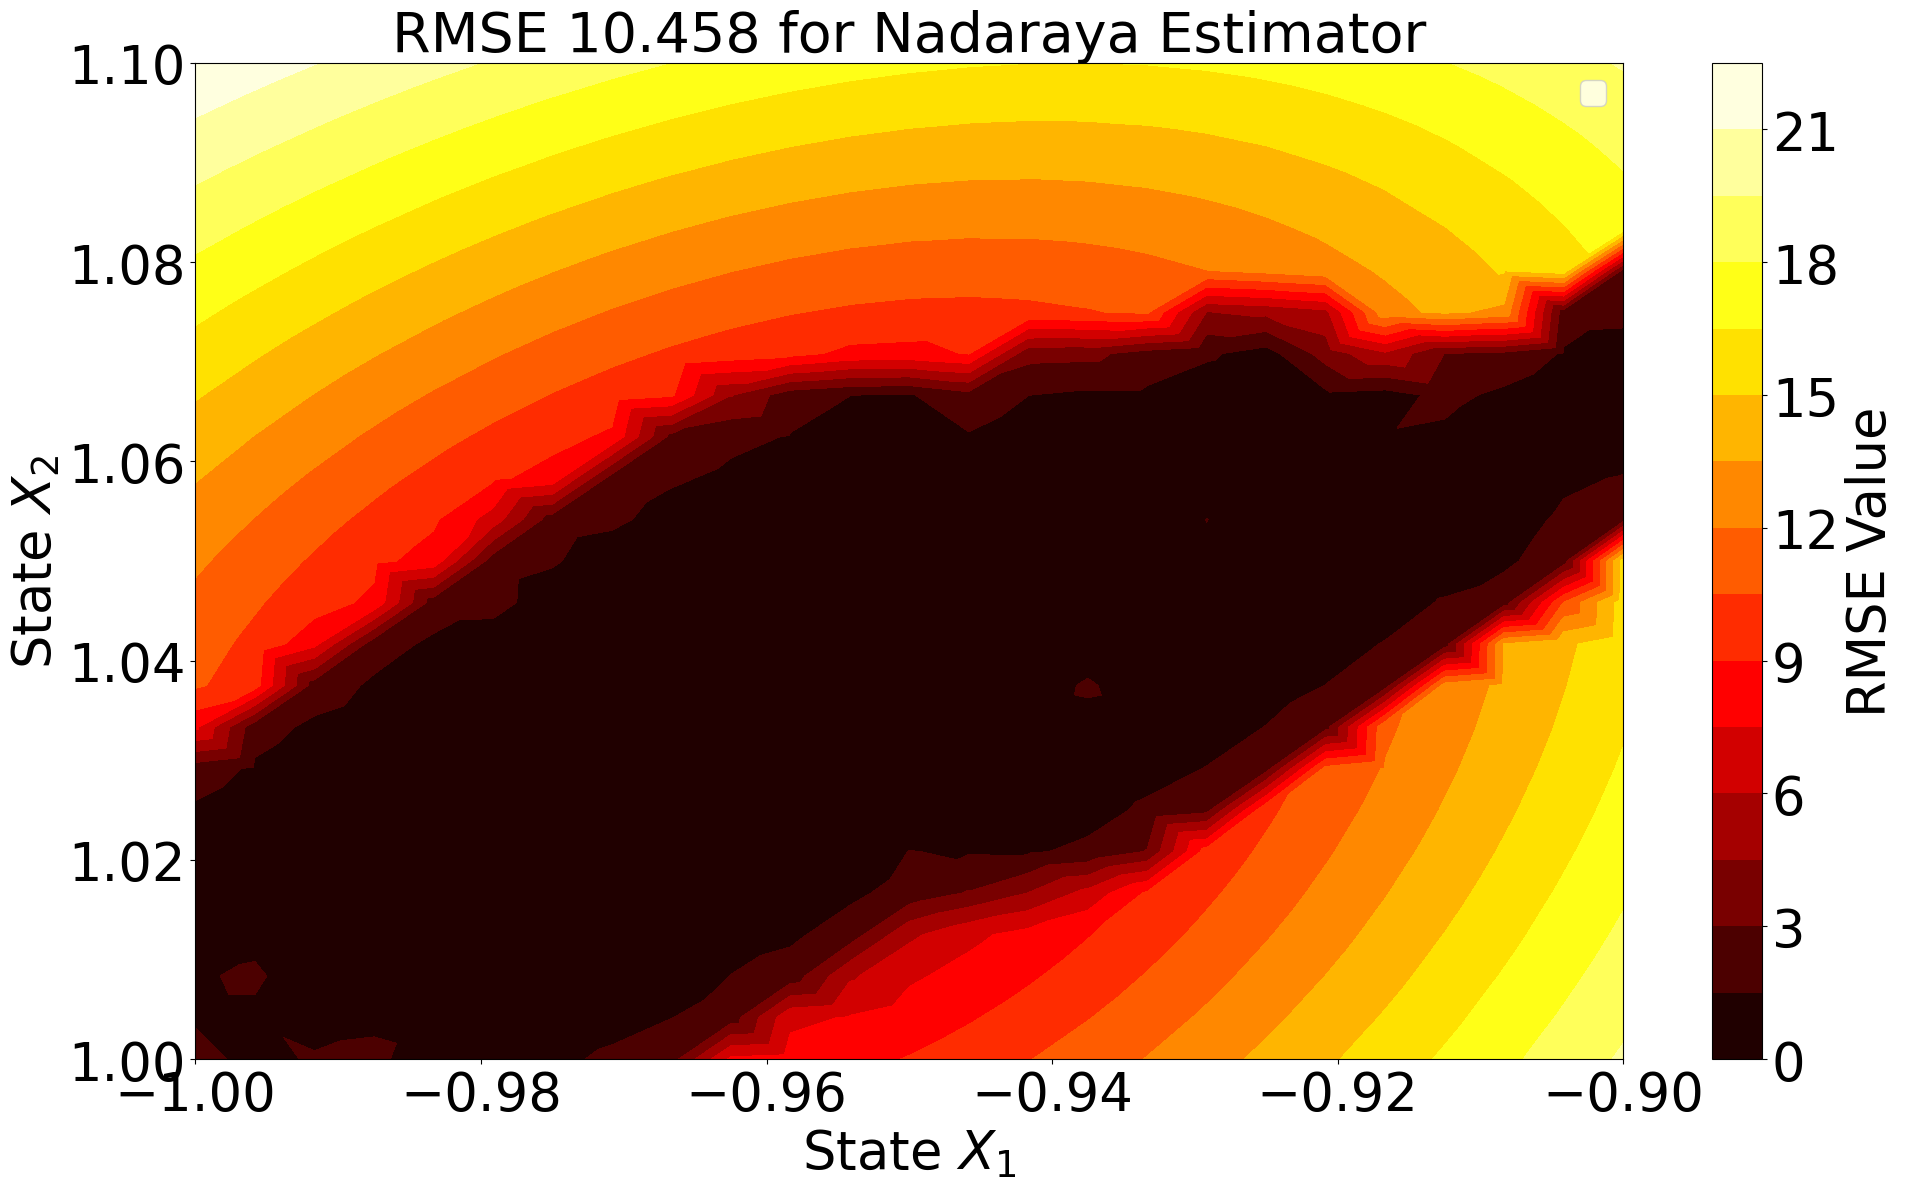

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bandwidth 2.541722919593772e-05 done with Best RMSE 10.45798483789146




BW IDX: 5



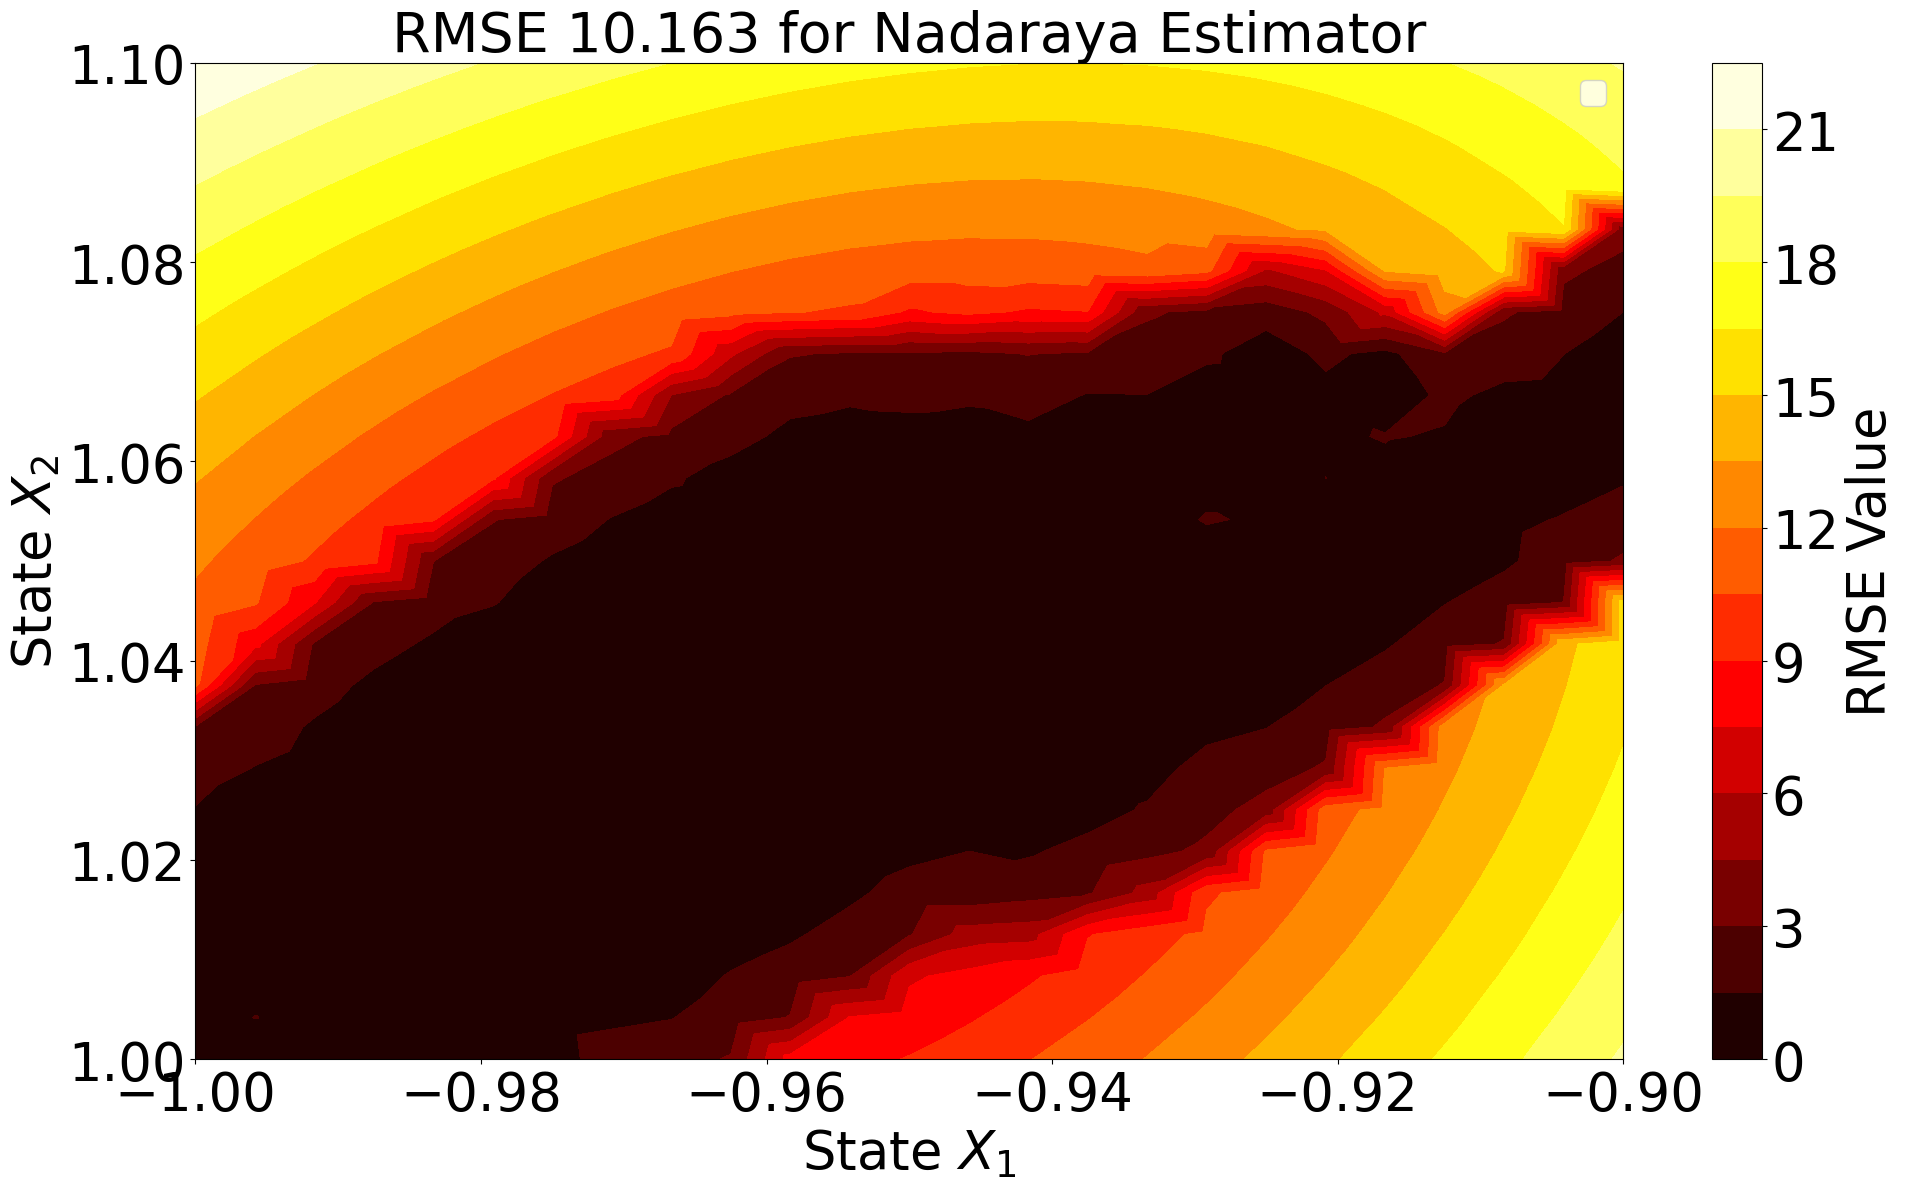

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bandwidth 3.2092995587978226e-05 done with Best RMSE 10.163381419018018




BW IDX: 6



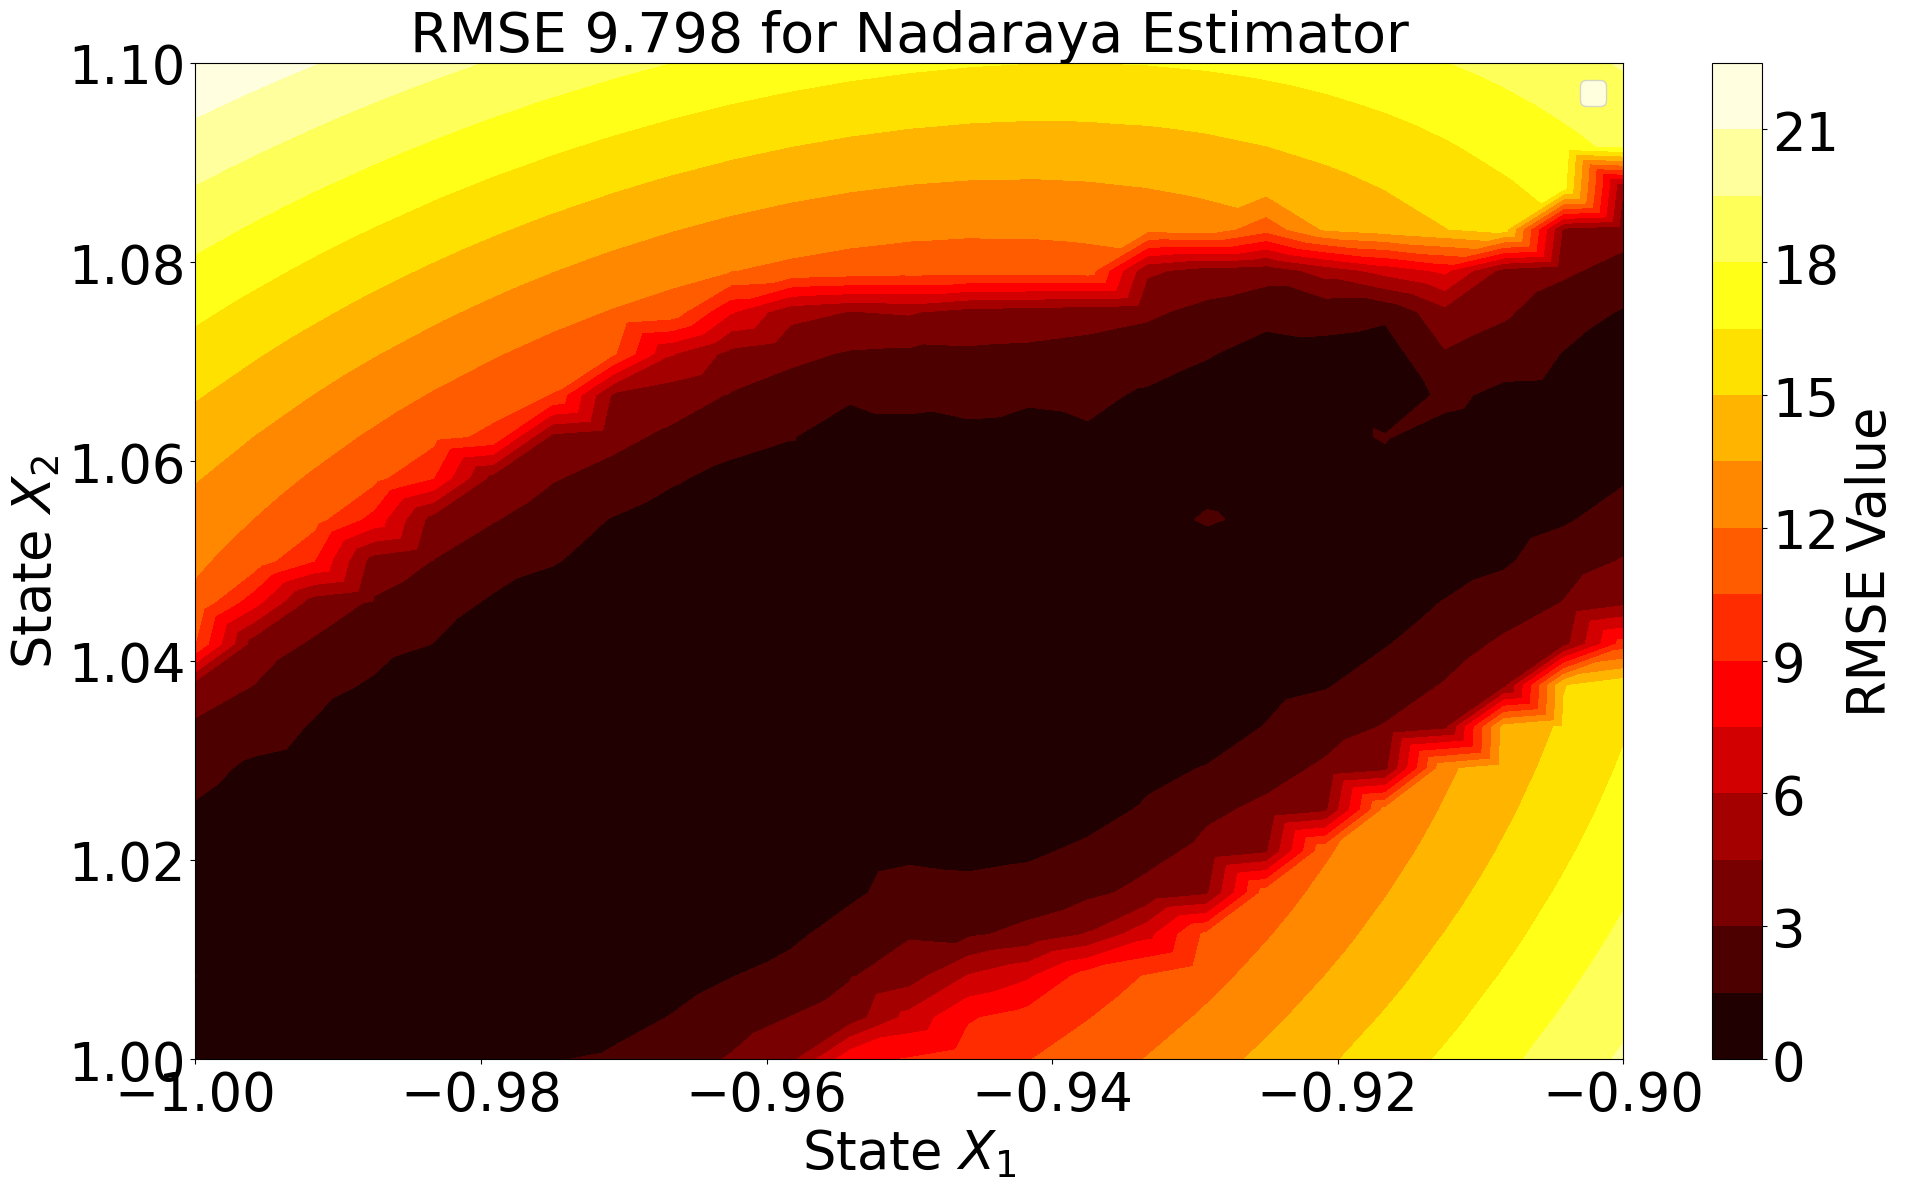

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bandwidth 4.052213393797473e-05 done with Best RMSE 9.797608457994752




BW IDX: 7



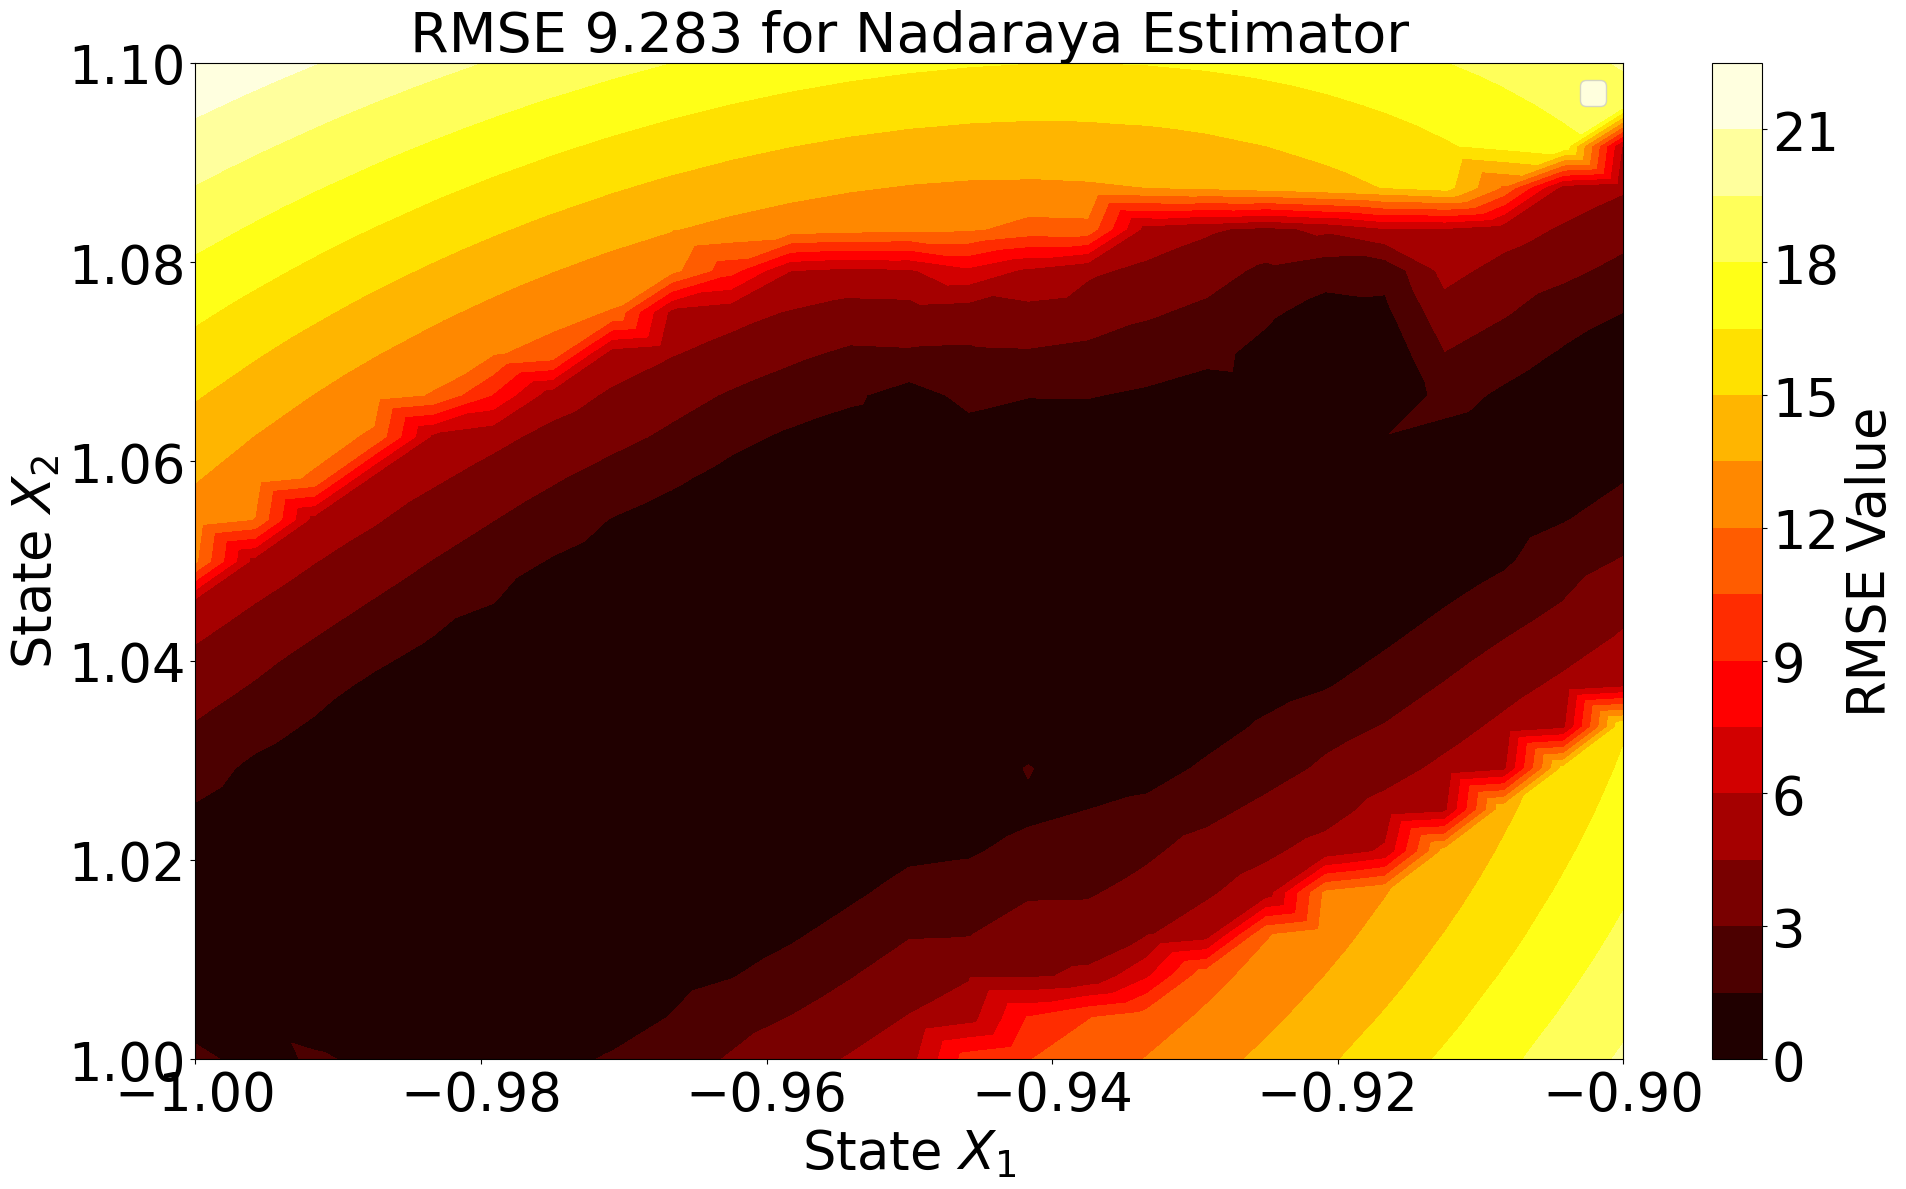

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bandwidth 5.116516264073084e-05 done with Best RMSE 9.283369468919748




BW IDX: 8



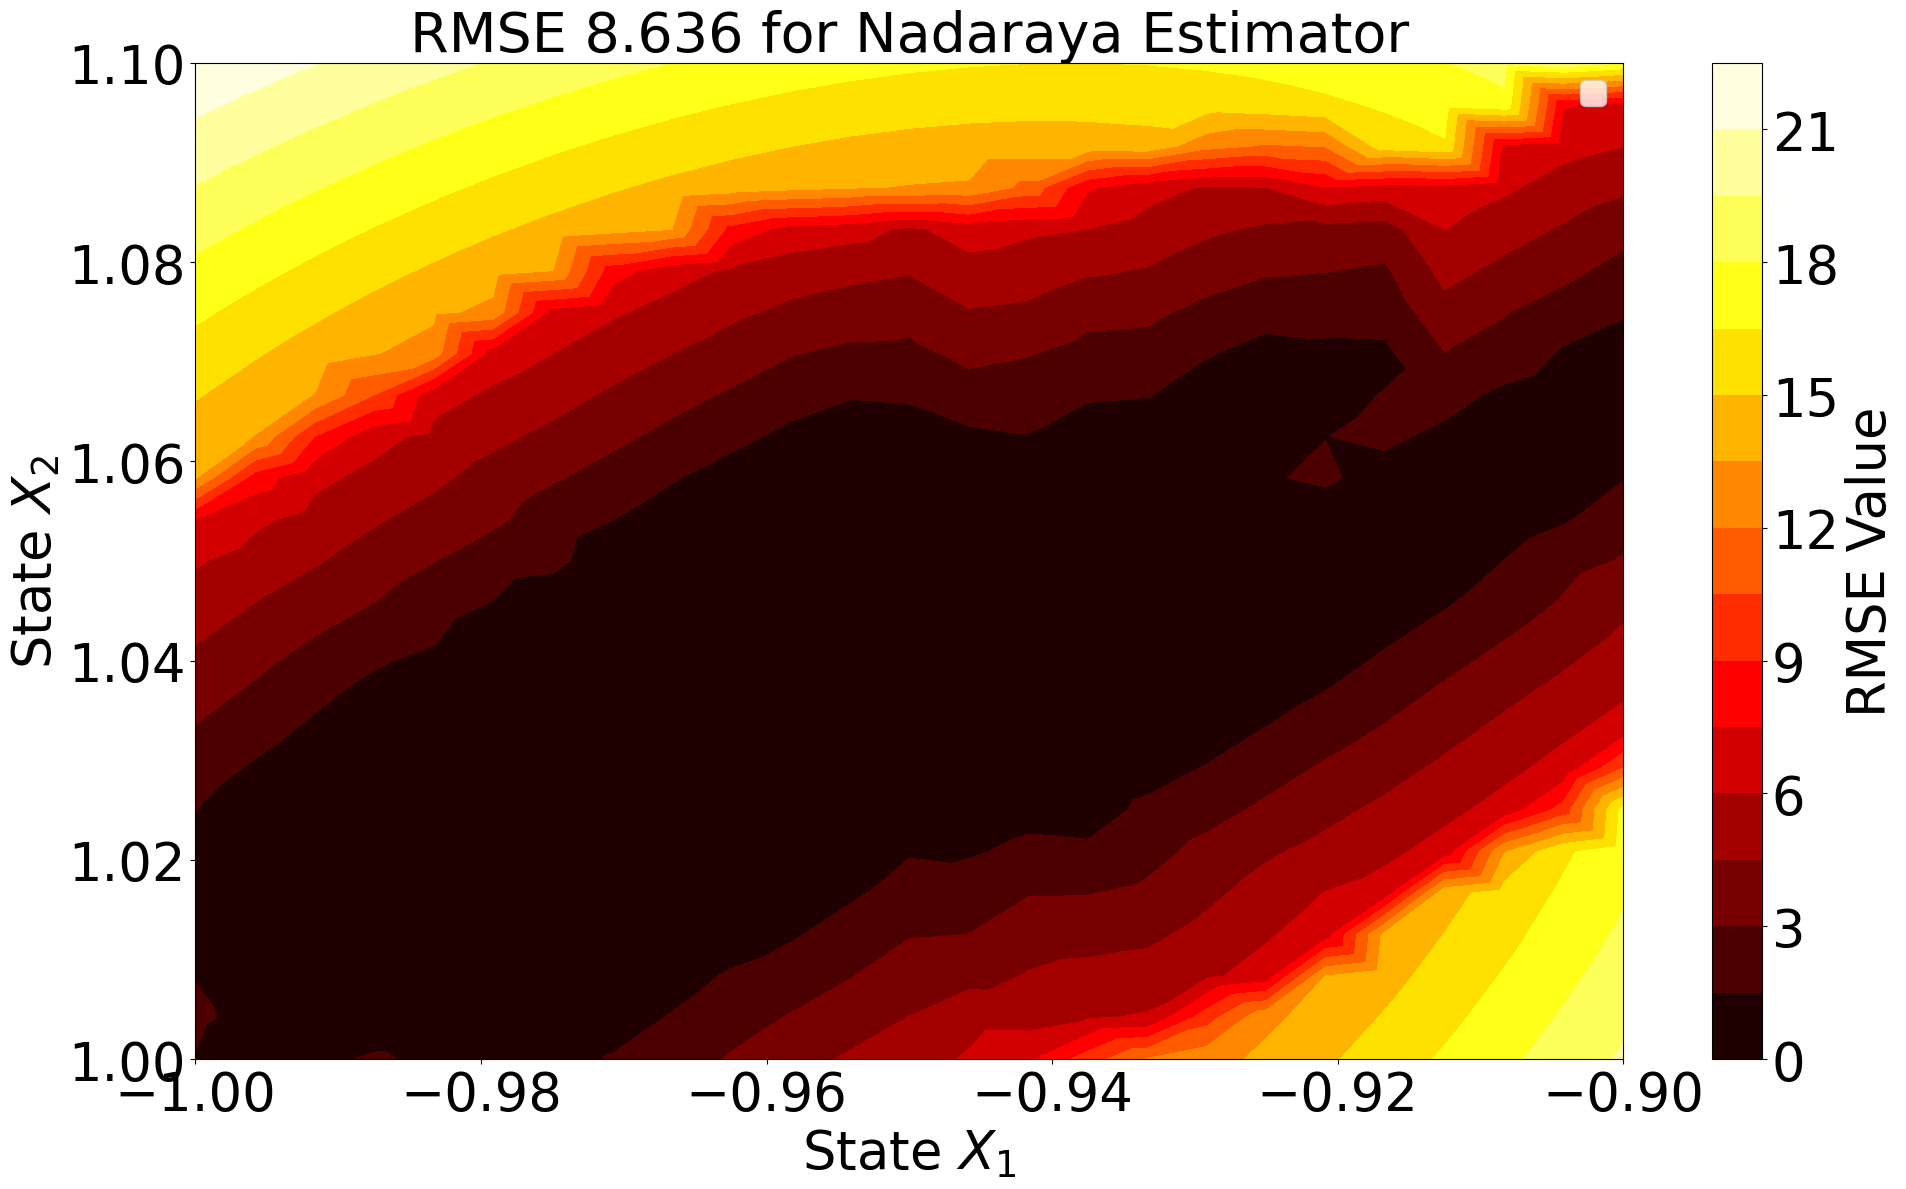

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bandwidth 6.460355399988287e-05 done with Best RMSE 8.635761887473898




BW IDX: 9



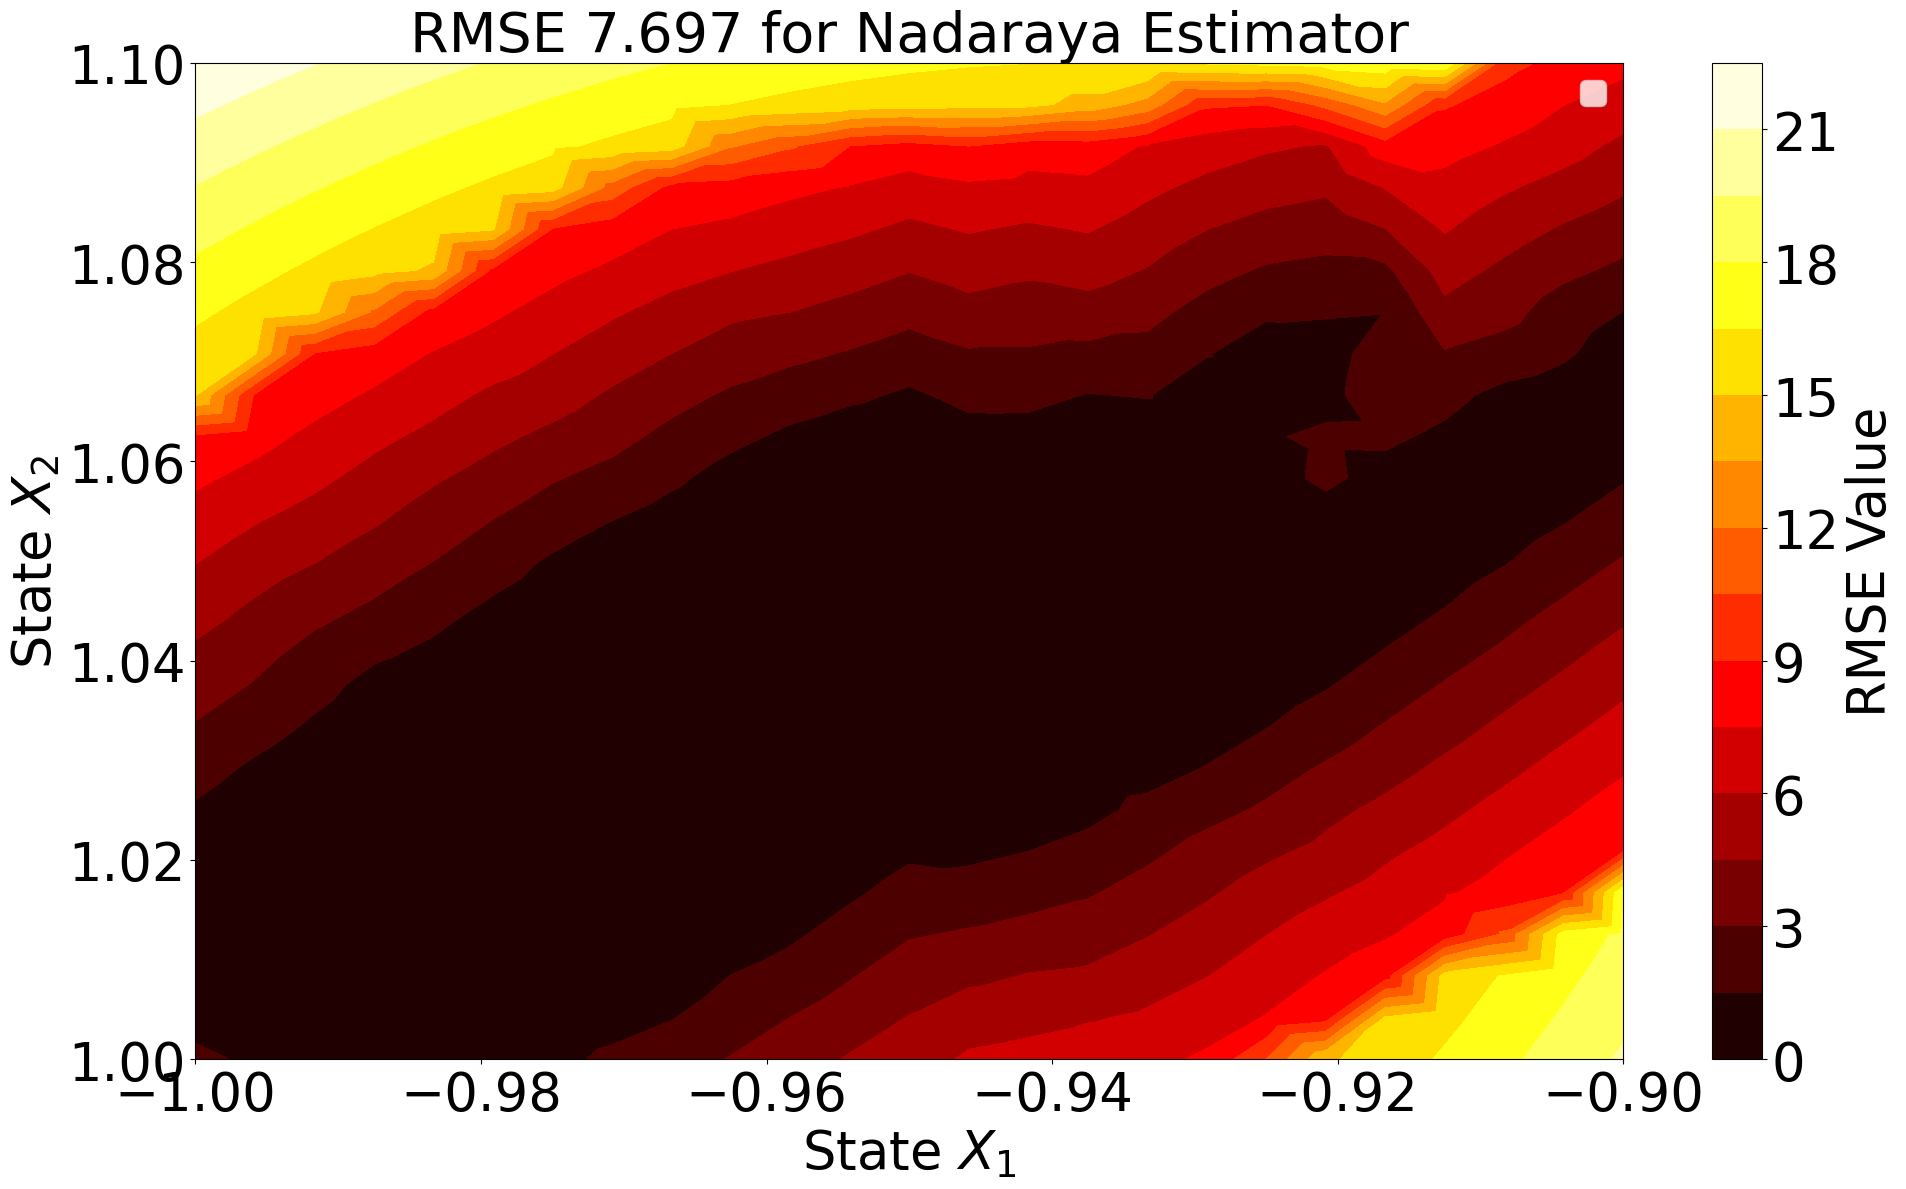

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bandwidth 8.157150244438605e-05 done with Best RMSE 7.697139148112116




BW IDX: 10



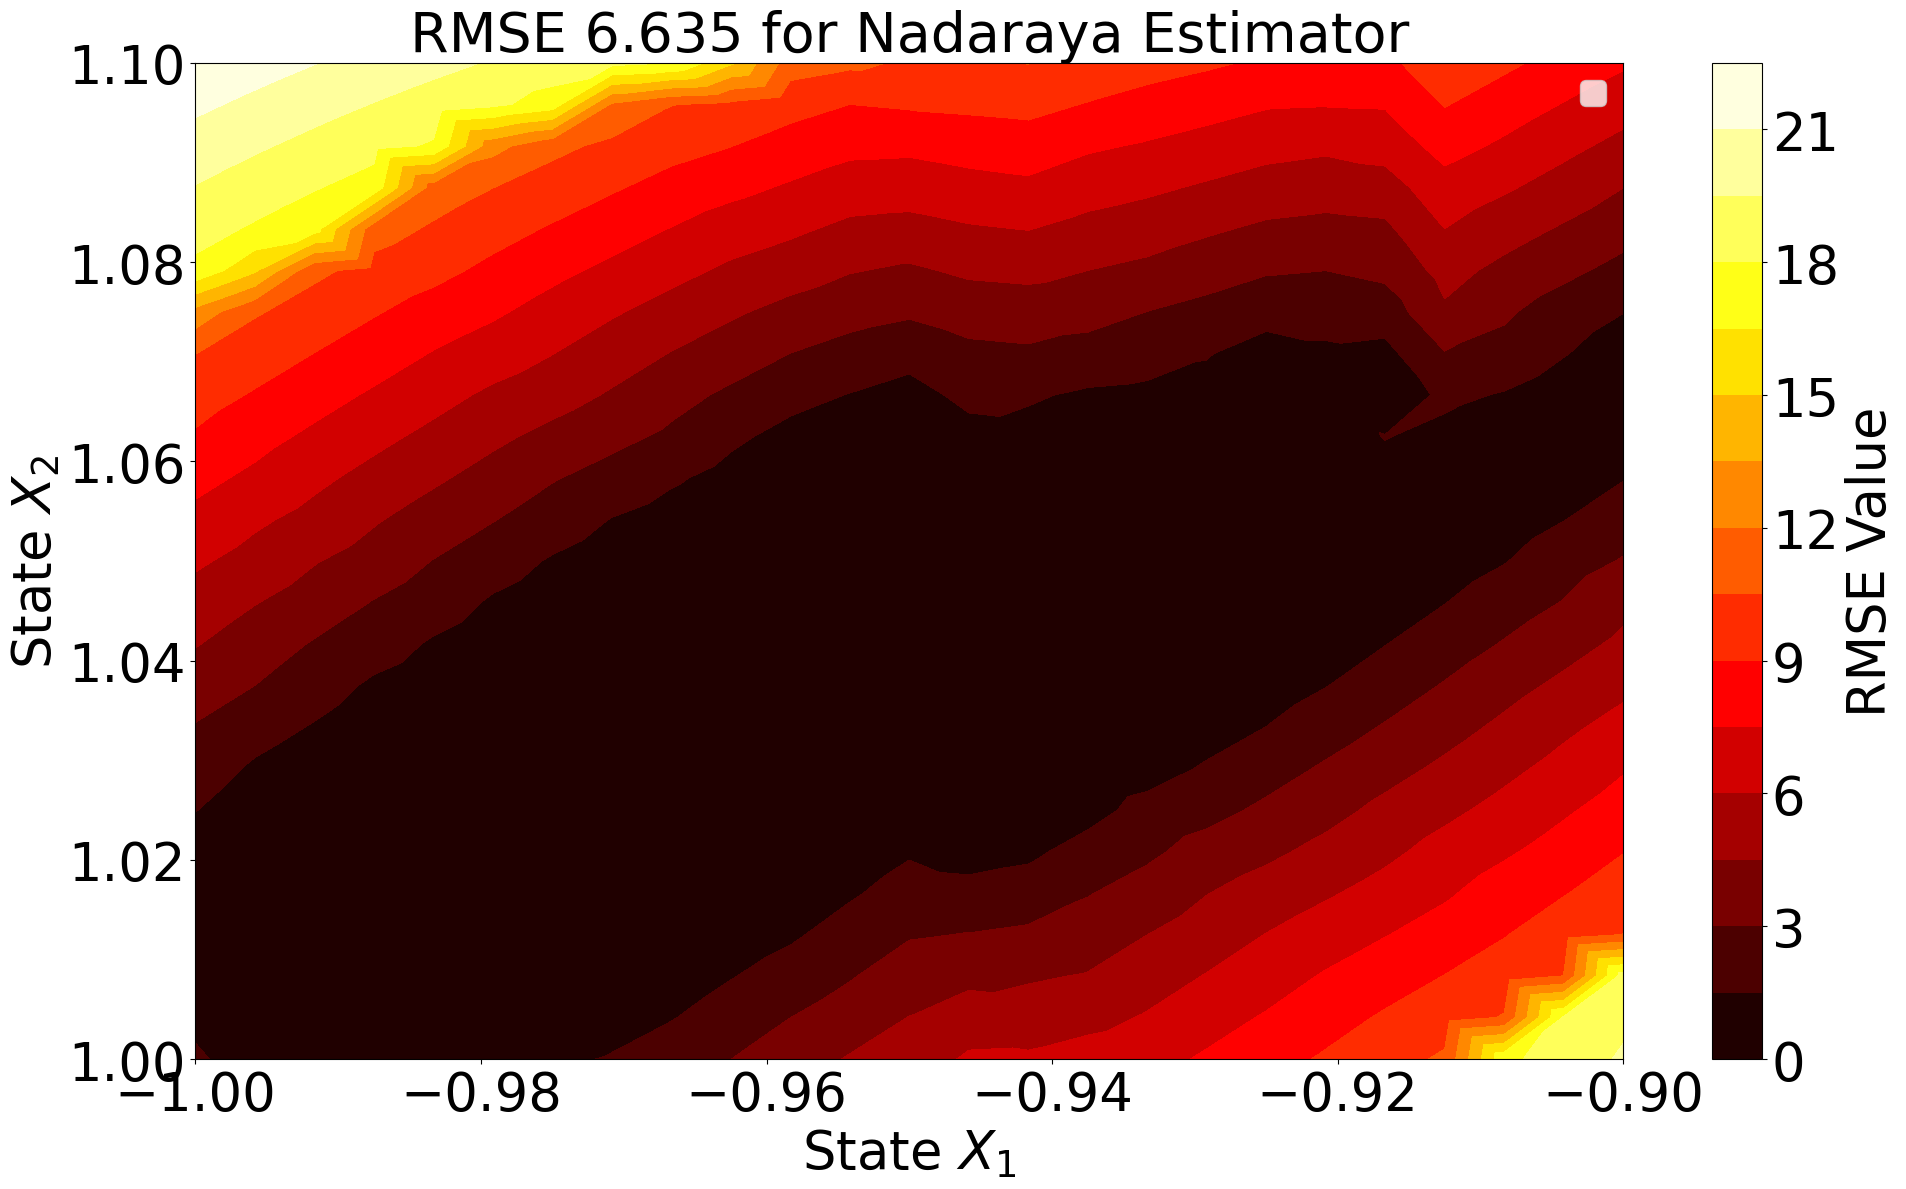

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bandwidth 0.00010299603658099897 done with Best RMSE 6.635175695867347




BW IDX: 11



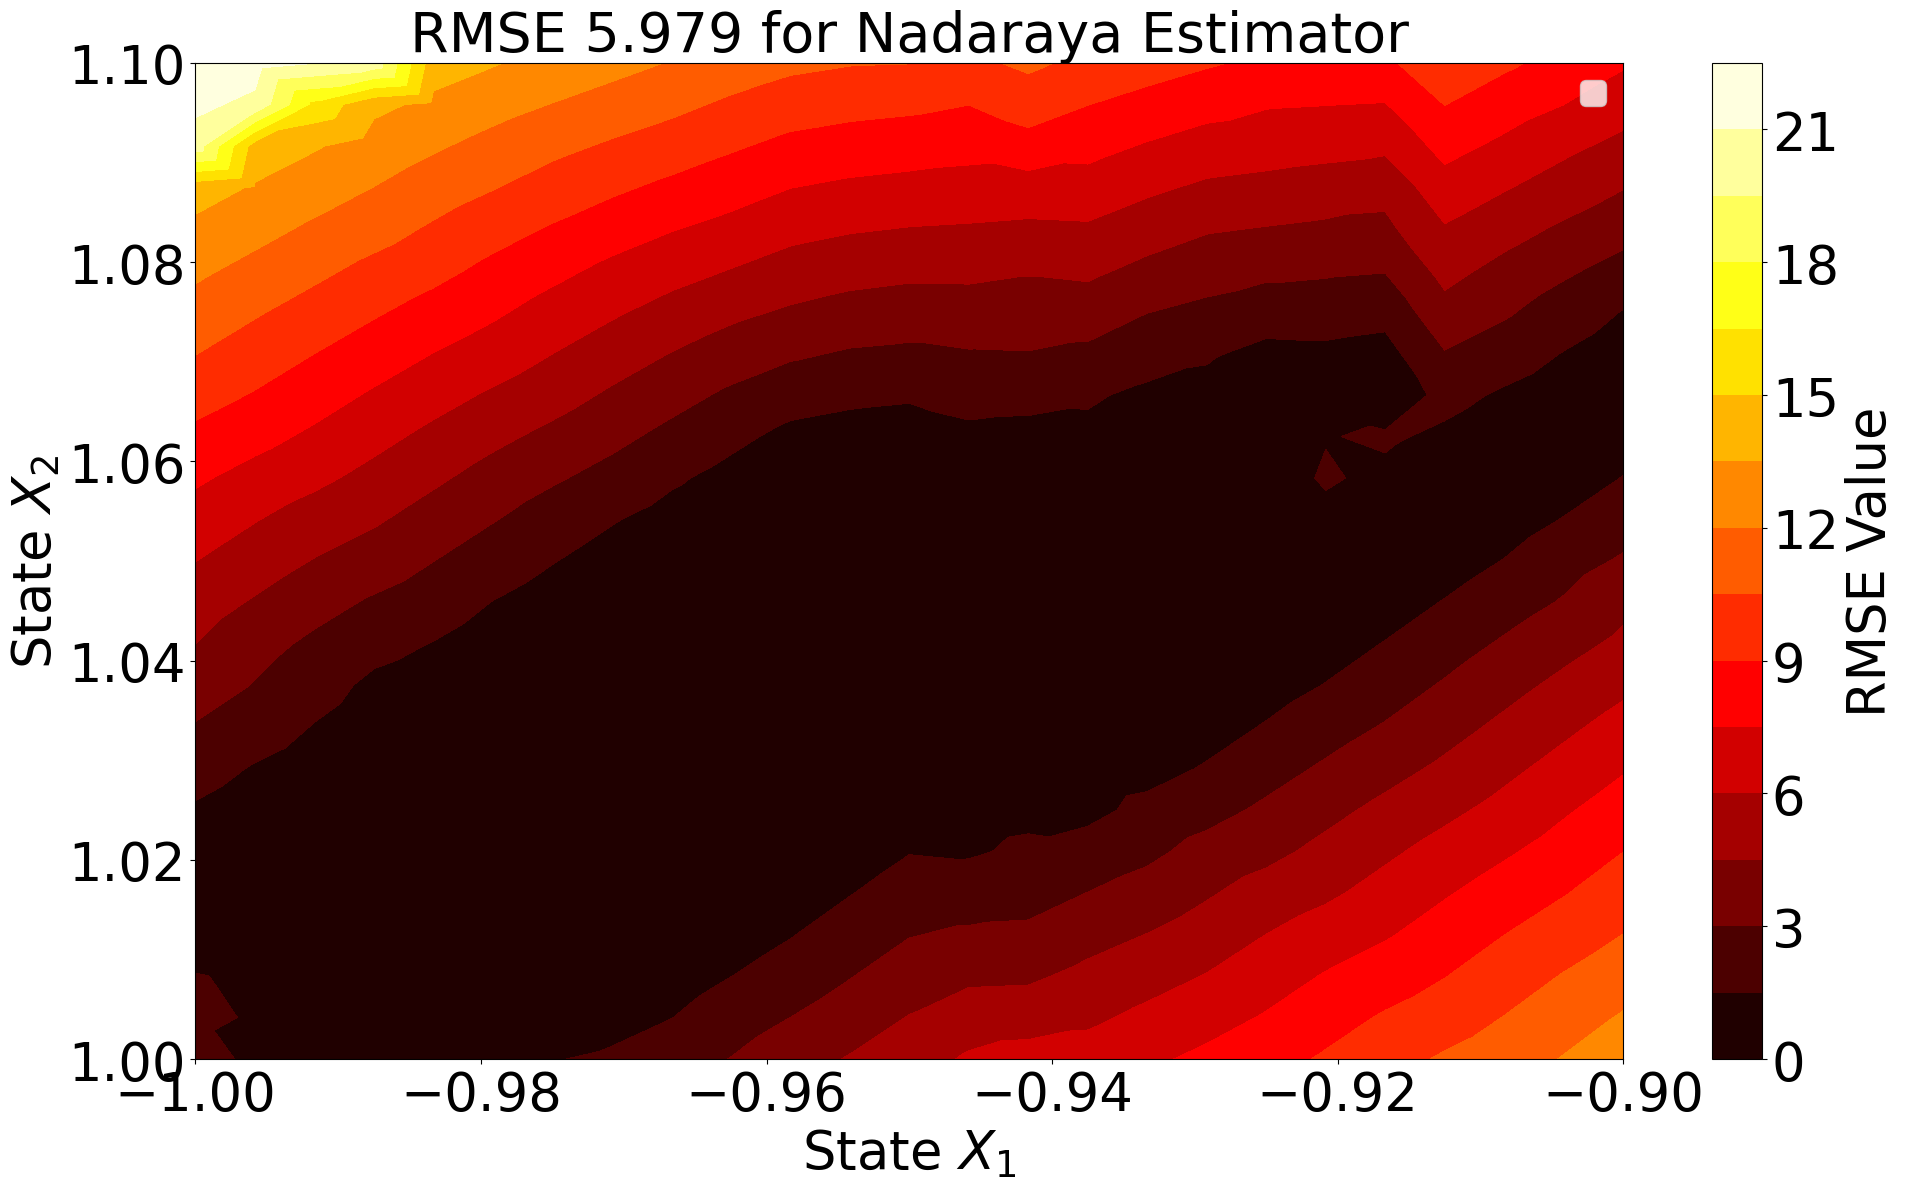

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bandwidth 0.00013004766656868856 done with Best RMSE 5.979233335538309




BW IDX: 12



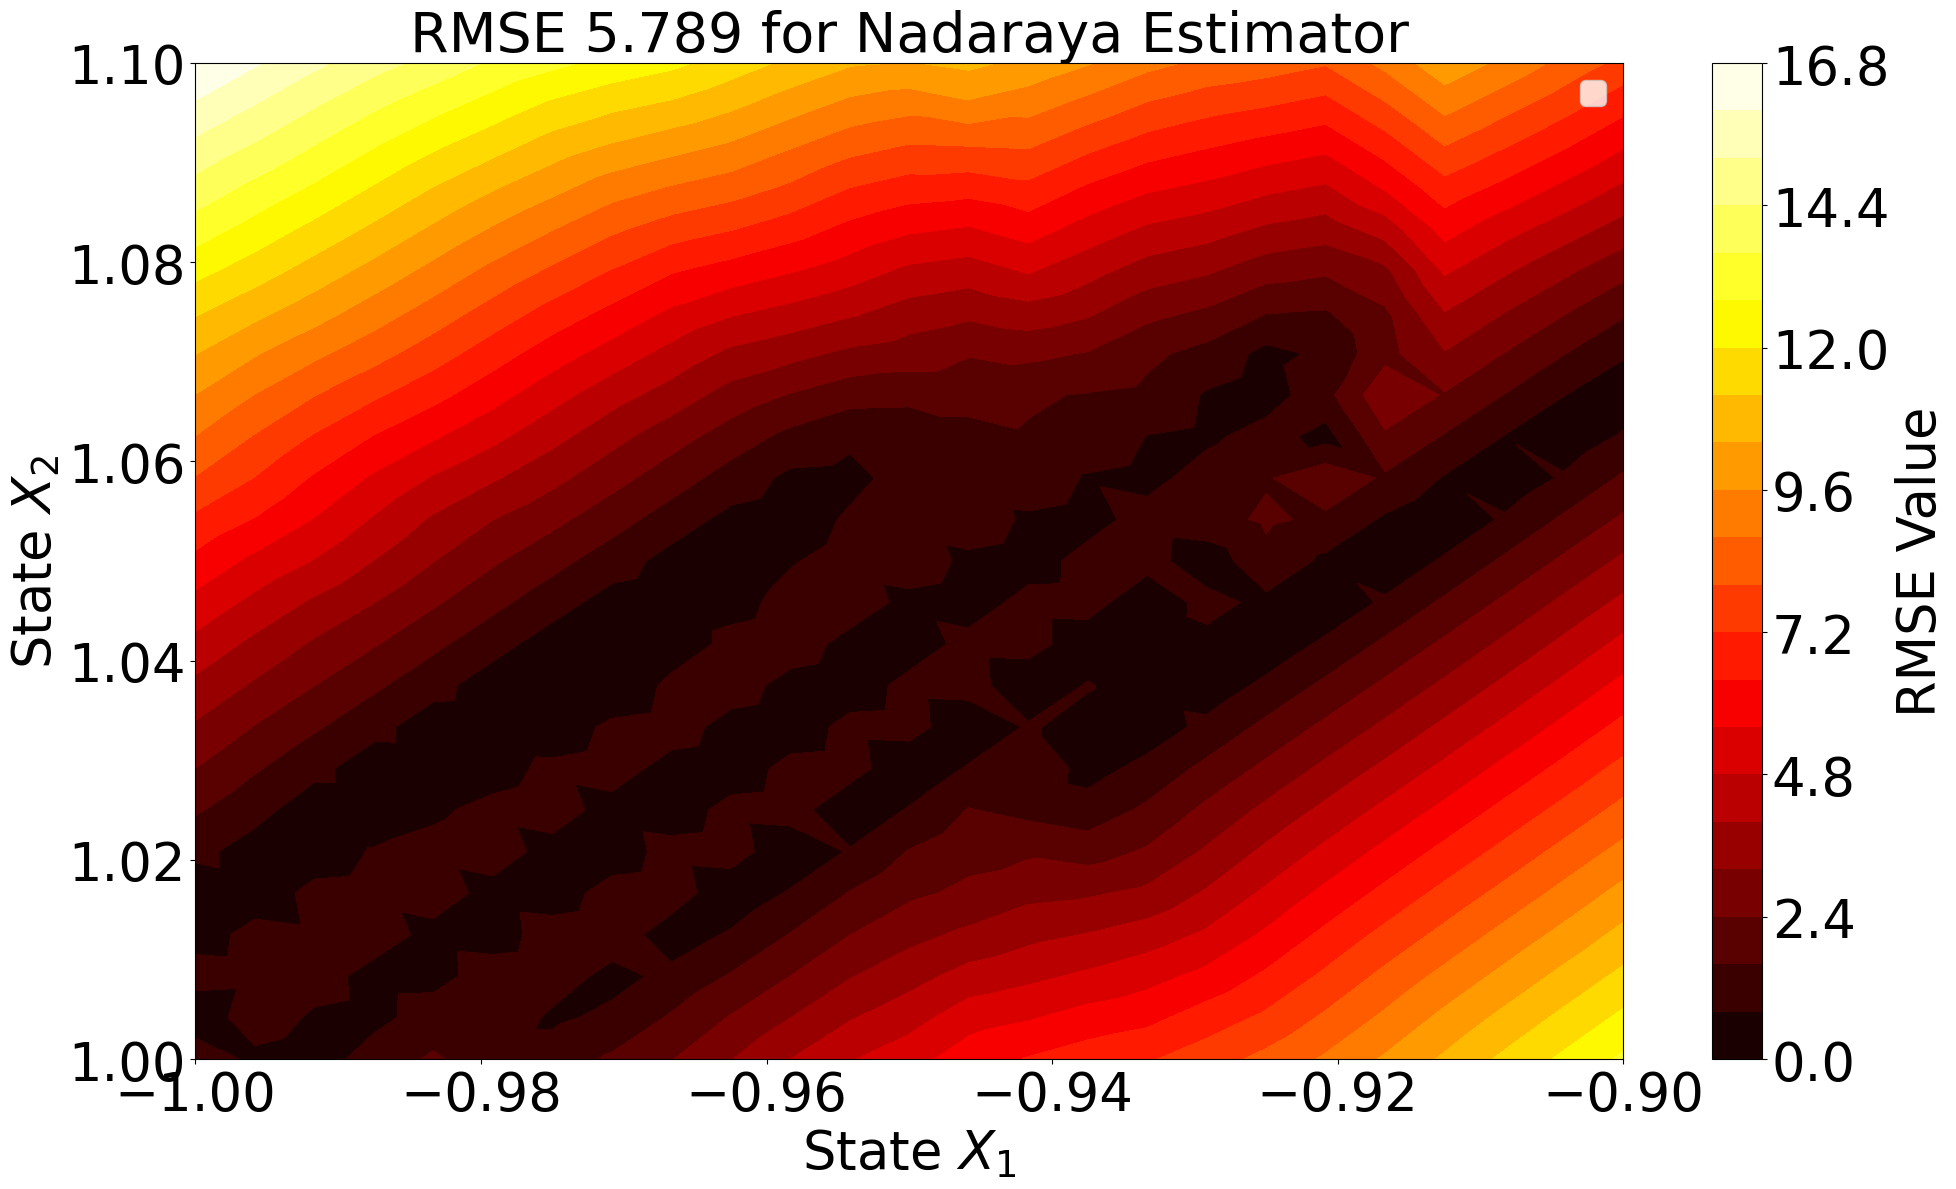

Bandwidth 0.0002073321573485954 done with Best RMSE 5.7893855753758645




BW IDX: 13

Bandwidth 0.00026178738680524396 done with Best RMSE 5.7893855753758645




BW IDX: 14

Bandwidth 0.00033054513475732445 done with Best RMSE 5.7893855753758645




BW IDX: 15

Bandwidth 0.0004173619189415786 done with Best RMSE 5.7893855753758645




BW IDX: 16

Bandwidth 0.0005269808963017477 done with Best RMSE 5.7893855753758645




BW IDX: 17

Bandwidth 0.000665391001103448 done with Best RMSE 5.7893855753758645




BW IDX: 18

Bandwidth 0.0008401541449729042 done with Best RMSE 5.7893855753758645




BW IDX: 19

Bandwidth 0.0010608183551394483 done with Best RMSE 5.7893855753758645




BW IDX: 20

Bandwidth 0.0013394394223182208 done with Best RMSE 5.7893855753758645




BW IDX: 21

Bandwidth 0.00169123955799608 done with Best RMSE 5.7893855753758645




BW IDX: 22

Bandwidth 0.002135439046269339 done with Best RMSE 5.7893855753758645




BW IDX: 23

Bandwidth 0.0026963063267837037 done with Bes

In [38]:
best_rmse = np.inf
toSave = True
i = 0
for fidx in range(len(keepfiles)):
    f = keepfiles[fidx]
    bw = bws[fidx]
    try:
        is_drift = np.load(f).mean(axis=1)
        assert (is_drift.shape == Xs.shape)
        rmse = rmse_ignore_nans(is_true_drifts, is_drift).astype(np.float64)#np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
        print(f"BW IDX: {i}\n")
        i+=1
        if rmse < best_rmse:
            best_rmse = rmse
            plot_drift_estimator(mean=is_drift, toSave=toSave, true_drift=is_true_drifts, bw=bw, coords=Xs)
        print(f"Bandwidth {bw} done with Best RMSE {best_rmse}\n\n\n\n")
    except ValueError as e:
        plt.close()
        continue
